# Проведение A/B-теста гипотез по увеличению выручки крупного интернет-магазина

Вы — аналитик крупного интернет-магазина. Вместе с отделом маркетинга вы подготовили список гипотез для увеличения выручки.

**Ваша задача:**

**1. приоритизировать гипотезы;**

**2. запустить A/B-тест и проанализировать результаты.**

**Для более быстрого погружения в ситуацию предоставляю описание данных:**

В вашем распоряжении три датасета. Файл ***/datasets/hypothesis.csv*** хранит информацию о посещениях сайта, ***/datasets/orders.csv*** — информацию о заказах, а ***/datasets/visitors.csv*** — хранит лог сервера с информацией о посещениях сайта.

Данные для первой части

**Структура /datasets/hypothesis.csv :**

- Hypothesis — краткое описание гипотезы;
- Reach — охват пользователей по 10-балльной шкале;
- Impact — влияние на пользователей по 10-балльной шкале;
- Confidence — уверенность в гипотезе по 10-балльной шкале;
- Efforts — затраты ресурсов на проверку гипотезы по 10-балльной шкале. Чем больше значение Efforts, тем дороже проверка гипотезы.

Данные для второй части

**Структура /datasets/orders.csv :**

- transactionId — идентификатор заказа;
- visitorId — идентификатор пользователя, совершившего заказ;
- date — дата, когда был совершён заказ;
- revenue — выручка заказа;
- group — группа A/B-теста, в которую попал заказ.

**Структура /datasets/visitors.csv :**

- date — дата;
- group — группа A/B-теста;
- visitors — количество пользователей в указанную дату в указанной группе A/B-теста


## Часть 1. Загрузка данных и подготовка их к анализу

In [1]:
import pandas as pd
import matplotlib.pyplot as plt 
import scipy.stats as stats
import datetime as dt
import numpy as np

# импортируем библиотеки 

import warnings
warnings.filterwarnings("ignore")
# предотвратим будущее появление предупреждений

**Заранее улчшим качество графиков и изменим параметры по умолчанию**

In [2]:
%config InlineBackend.figure_format = 'retina' 
# устанавливаем конфиг, повыщающий разрешение графиков
%matplotlib inline
# устанавливаем конфиг, повыщающий разрешение графиков
plt.style.use('seaborn-whitegrid')
from pylab import rcParams
rcParams['figure.figsize'] = 14,6

**Откроем файлы с данными и изучим общую информацию**

In [3]:
try:
    hypothesis = pd.read_csv('/datasets/hypothesis.csv')
    orders = pd.read_csv('/datasets/orders.csv')
    visitors = pd.read_csv('/datasets/visitors.csv')
except: 
    hypothesis = pd.read_csv('/Users/whyyoutried/Documents/Practicum/project sprint 13:21/hypothesis.csv')
    orders = pd.read_csv('/Users/whyyoutried/Documents/Practicum/project sprint 13:21/orders.csv')
    visitors = pd.read_csv('/Users/whyyoutried/Documents/Practicum/project sprint 13:21/visitors.csv')    

In [4]:
hypothesis.head()
# посмотрим на таблицу c гипотезами

,Hypothesis,Reach,Impact,Confidence,Efforts
0,"Добавить два новых канала привлечения трафика,...",3,10,8,6
1,"Запустить собственную службу доставки, что сок...",2,5,4,10
2,Добавить блоки рекомендаций товаров на сайт ин...,8,3,7,3
3,"Изменить структура категорий, что увеличит кон...",8,3,3,8
4,"Изменить цвет фона главной страницы, чтобы уве...",3,1,1,1


In [5]:
orders.head()
# посмотрим на таблицу заказов

,transactionId,visitorId,date,revenue,group
0,3667963787,3312258926,2019-08-15,1650,B
1,2804400009,3642806036,2019-08-15,730,B
2,2961555356,4069496402,2019-08-15,400,A
3,3797467345,1196621759,2019-08-15,9759,B
4,2282983706,2322279887,2019-08-15,2308,B


In [6]:
visitors.head()
# посмотрим на таблицу посещений

,date,group,visitors
0,2019-08-01,A,719
1,2019-08-02,A,619
2,2019-08-03,A,507
3,2019-08-04,A,717
4,2019-08-05,A,756


**Комментарий к полученному выводу:**

- названия столбцов нужно привести к общепринятому формату (snake_case)

**Далее мы исправим вышеупомянутый недочет, а также проверим типы данных этих таблиц**

In [7]:
hypothesis.columns = hypothesis.columns.str.lower()
# приводим названия столбцов к классическому виду 
hypothesis.head()
# смотрим на итог

,hypothesis,reach,impact,confidence,efforts
0,"Добавить два новых канала привлечения трафика,...",3,10,8,6
1,"Запустить собственную службу доставки, что сок...",2,5,4,10
2,Добавить блоки рекомендаций товаров на сайт ин...,8,3,7,3
3,"Изменить структура категорий, что увеличит кон...",8,3,3,8
4,"Изменить цвет фона главной страницы, чтобы уве...",3,1,1,1


In [8]:
orders = orders.rename(columns={'transactionId': 'transaction_id', 'visitorId': 'visitor_id'})
# приводим названия столбцов к классическому виду 
orders.head()
# смотрим на итог

,transaction_id,visitor_id,date,revenue,group
0,3667963787,3312258926,2019-08-15,1650,B
1,2804400009,3642806036,2019-08-15,730,B
2,2961555356,4069496402,2019-08-15,400,A
3,3797467345,1196621759,2019-08-15,9759,B
4,2282983706,2322279887,2019-08-15,2308,B


In [9]:
orders.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1197 entries, 0 to 1196
Data columns (total 5 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   transaction_id  1197 non-null   int64 
 1   visitor_id      1197 non-null   int64 
 2   date            1197 non-null   object
 3   revenue         1197 non-null   int64 
 4   group           1197 non-null   object
dtypes: int64(3), object(2)
memory usage: 46.9+ KB


In [10]:
hypothesis.duplicated().sum()
# проверка на наличие явных дубликатов

0

In [11]:
orders.duplicated().sum()
# проверка на наличие явных дубликатов

0

In [12]:
visitors.duplicated().sum()
# проверка на наличие явных дубликатов

0

**Промежуточный вывод по этапу предобработки данных:**

- названия столбцов приведены к общепринятому стилю - snake_case
- у столбца с датой типы данных соответсвующий
- пропуски отсутсвуют
- явных дубликатов в таблицах нет

**Однако на этом предобработка данных не заканчивается, далее мы проверим качество разбиения пользователей по группам**

In [13]:
orders[orders['group'] == 'A']['visitor_id'].isin(orders[orders['group'] == 'B']['visitor_id']).sum()
# проверям сколько пользователей оказалось в 2-ух группах одновременно

89

**89 пользователей оказалось в 2-ух выборках одновременно - надо исключить их из обеих групп, чтобы не исказить данные**


In [14]:
double_users = orders.groupby('visitor_id', as_index=False).agg({'group' : 'nunique'}) \
                     .query('group>1')['visitor_id'].unique()
# составим список айдишников пользователей, которые оказались в 2-ух группах одновременно

In [15]:
orders = orders.query('visitor_id not in @double_users')
# исключим этих пользователей и их заказы из нашего датасета с ордерами

In [16]:
orders[orders['group'] == 'A']['visitor_id'].isin(orders[orders['group'] == 'B']['visitor_id']).sum()
# проверим что все сработало корректно

0

**Финальный вывод по этапу предобработки данных:**

Итого, на этапе предобработки данных мы:

- привели названия столбцов к общепринятому стилю - snake_case
- убедились в корректности типов данных у всех столбцов
- проверили данные на наличие пропусков и явных дубликатов
- исключили дублирующиеся данные из таблицы с заказами

**Далее переходим к приоритизации гипотез**

## Часть 2. Приоритизация гипотез

In [17]:
hypothesis['ICE'] = hypothesis['impact'] * hypothesis['confidence'] / hypothesis['efforts']
# создаем столбец с ICE-scor'ом 
hypothesis.sort_values(by='ICE', ascending=False).head()
# выводим топ 5 гипотез

,hypothesis,reach,impact,confidence,efforts,ICE
8,"Запустить акцию, дающую скидку на товар в день...",1,9,9,5,16.200000
0,"Добавить два новых канала привлечения трафика,...",3,10,8,6,13.333333
7,Добавить форму подписки на все основные страни...,10,7,8,5,11.200000
6,Показать на главной странице баннеры с актуаль...,5,3,8,3,8.000000
2,Добавить блоки рекомендаций товаров на сайт ин...,8,3,7,3,7.000000


**Комментарий к приоритизации по фреймворку "ICE":**

- поскольку не видно полные названия гипотез снимем ограничения на ширину колонки

In [18]:
pd.set_option('display.max_colwidth', None)
# снимаем ограничение на кол-во символов в колонке

In [19]:
hypothesis.sort_values(by='ICE', ascending=False)
# выводим топ 5 гипотез

,hypothesis,reach,impact,confidence,efforts,ICE
8,"Запустить акцию, дающую скидку на товар в день рождения",1,9,9,5,16.200000
0,"Добавить два новых канала привлечения трафика, что позволит привлекать на 30% больше пользователей",3,10,8,6,13.333333
7,"Добавить форму подписки на все основные страницы, чтобы собрать базу клиентов для email-рассылок",10,7,8,5,11.200000
6,"Показать на главной странице баннеры с актуальными акциями и распродажами, чтобы увеличить конверсию",5,3,8,3,8.000000
2,"Добавить блоки рекомендаций товаров на сайт интернет магазина, чтобы повысить конверсию и средний чек заказа",8,3,7,3,7.000000
1,"Запустить собственную службу доставки, что сократит срок доставки заказов",2,5,4,10,2.000000
5,"Добавить страницу отзывов клиентов о магазине, что позволит увеличить количество заказов",3,2,2,3,1.333333
3,"Изменить структура категорий, что увеличит конверсию, т.к. пользователи быстрее найдут нужный товар",8,3,3,8,1.125000
4,"Изменить цвет фона главной страницы, чтобы увеличить вовлеченность пользователей",3,1,1,1,1.000000


**Комментарий к приоритизации по фреймворку "ICE":**

Приоритезируя гипотезы, по фреймворку "ICE" мы получили следующие топ-5 гипотез:

1. "*Запустить акцию, дающую скидку на товар в день рождения*"
2. "*Добавить два новых канала привлечения трафика, что позволит привлекать на 30% больше пользователей*"
3. "*Добавить форму подписки на все основные страницы, чтобы собрать базу клиентов для email-рассылок*"
4. "*Показать на главной странице баннеры с актуальными акциями и распродажами, чтобы увеличить конверсию*"
5. "*Добавить блоки рекомендаций товаров на сайт интернет магазина, чтобы повысить конверсию и средний чек заказа*"

**Далее мы отранжируем гипотезы с учетом их потенциального охвата пользователей**

In [20]:
hypothesis['RICE'] = hypothesis['reach'] * hypothesis['impact'] * hypothesis['confidence'] / hypothesis['efforts']
# создаем столбец с RICE-scor'ом 
hypothesis.sort_values(by='RICE', ascending=False)
# выводим топ 5 гипотез

,hypothesis,reach,impact,confidence,efforts,ICE,RICE
7,"Добавить форму подписки на все основные страницы, чтобы собрать базу клиентов для email-рассылок",10,7,8,5,11.200000,112.0
2,"Добавить блоки рекомендаций товаров на сайт интернет магазина, чтобы повысить конверсию и средний чек заказа",8,3,7,3,7.000000,56.0
0,"Добавить два новых канала привлечения трафика, что позволит привлекать на 30% больше пользователей",3,10,8,6,13.333333,40.0
6,"Показать на главной странице баннеры с актуальными акциями и распродажами, чтобы увеличить конверсию",5,3,8,3,8.000000,40.0
8,"Запустить акцию, дающую скидку на товар в день рождения",1,9,9,5,16.200000,16.2
3,"Изменить структура категорий, что увеличит конверсию, т.к. пользователи быстрее найдут нужный товар",8,3,3,8,1.125000,9.0
1,"Запустить собственную службу доставки, что сократит срок доставки заказов",2,5,4,10,2.000000,4.0
5,"Добавить страницу отзывов клиентов о магазине, что позволит увеличить количество заказов",3,2,2,3,1.333333,4.0
4,"Изменить цвет фона главной страницы, чтобы увеличить вовлеченность пользователей",3,1,1,1,1.000000,3.0


**Комментарий к приоритизации по фреймворку "RICE":**

Приоритезируя гипотезы, по фреймворку "RICE" мы получили следующие топ-5 гипотез:

1. "*Добавить форму подписки на все основные страницы, чтобы собрать базу клиентов для email-рассылок*"
2. "*Добавить блоки рекомендаций товаров на сайт интернет магазина, чтобы повысить конверсию и средний чек заказа*"
3. "*Добавить два новых канала привлечения трафика, что позволит привлекать на 30% больше пользователей*"
4. "*Показать на главной странице баннеры с актуальными акциями и распродажами, чтобы увеличить конверсию*"
5. "*Запустить акцию, дающую скидку на товар в день рождения*"

Таким образом, можем заметить, что наиболее приоритетной гипотезой с учетом охвата стала ***фича со сбором email'ов наших пользователей***, хоть по шкале ICE даннная инициатива ***была лишь третьей по приоритетности***, а идея со ***скидками на день рождения***, которая была наиболее приоритетной гипотезой по шкале ICE, при учете потенциального охвата ***переместилась на 5 строчку***. Это объясняется тем, что получать скидку на день рождения наши пользователи будут лишь раз в год, а вот собирать email'ы посетителей нашего сайта мы можем каждый день, и естественно, у второй инициативы охват гораздо больше, что и влияет на приоритетность фичи 

## Часть 3. Анализ A/B-теста



In [21]:
ordersADaily = (
    orders[orders['group'] == 'A'][['date', 'transaction_id', 'visitor_id', 'revenue']]
    .groupby('date', as_index=False)
    .agg({'transaction_id': 'nunique', 'revenue': 'sum'})
    .rename(columns={'transaction_id': 'orders_per_day', 'revenue': 'revenue_per_day'})
)
# создаем таблицу заказов пользователей из группы 'A' с группировкой по дате 

In [22]:
ordersACummulative = ordersADaily.apply(
    lambda x: ordersADaily[ordersADaily['date'] <= x['date']].agg(
    {'date': 'max','orders_per_day': 'sum', 'revenue_per_day': 'sum'}
    ),
    axis = 1
).rename(columns={'orders_per_day': 'total_orders', 'revenue_per_day': 'total_revenue'}) \
 .sort_values(by='date')
# создаем таблицу кумулятивных данных пользователей из группы А с группировкой по дате

In [23]:
ordersBDaily = (
    orders[orders['group'] == 'B'][['date', 'transaction_id', 'visitor_id', 'revenue']]
    .groupby('date', as_index=False)
    .agg({'transaction_id': 'nunique', 'revenue': 'sum'})
    .rename(columns={'transaction_id': 'orders_per_day', 'revenue': 'revenue_per_day'})
)
# создаем таблицу заказов пользователей из группы 'B' с группировкой по дате 

In [24]:
ordersBCummulative = ordersBDaily.apply(
    lambda x: ordersBDaily[ordersBDaily['date'] <= x['date']].agg(
    {'date': 'max','orders_per_day': 'sum', 'revenue_per_day': 'sum'}
    ),
    axis = 1
).rename(columns={'orders_per_day': 'total_orders', 'revenue_per_day': 'total_revenue'}) \
 .sort_values(by='date')
# создаем таблицу кумулятивных данных пользователей из группы 'B' с группировкой по дате

In [25]:
DailyVisitsA = visitors.query('group=="A"')
# создаем таблицу с ежедневным количеством посетителей из группы 'A'
DailyVisitsB = visitors.query('group=="B"')
# создаем таблицу с ежедневным количеством посетителей из группы 'B'

In [26]:
visitorsACummulative = DailyVisitsA \
    .apply(
    lambda x: DailyVisitsA[DailyVisitsA['date'] <= x['date']].agg(
    {'date': 'max', 'visitors': 'sum'}
    ),
    axis=1
).rename(columns={'visitors': 'visits_per_day'}) \
 .sort_values(by='date')
# создаем таблицу кумулятивного значения посещений пользователей из группы 'A'

In [27]:
visitorsBCummulative = DailyVisitsB.query('group=="B"') \
    .apply(
    lambda x: DailyVisitsB[DailyVisitsB['date'] <= x['date']].agg(
    {'date': 'max', 'visitors': 'sum'}
    ),
    axis=1
).reset_index() \
 .rename(columns={'visitors': 'visits_per_day'}) \
 .sort_values(by='date')
# создаем таблицу кумулятивного значения посещений пользователей из группы 'B'

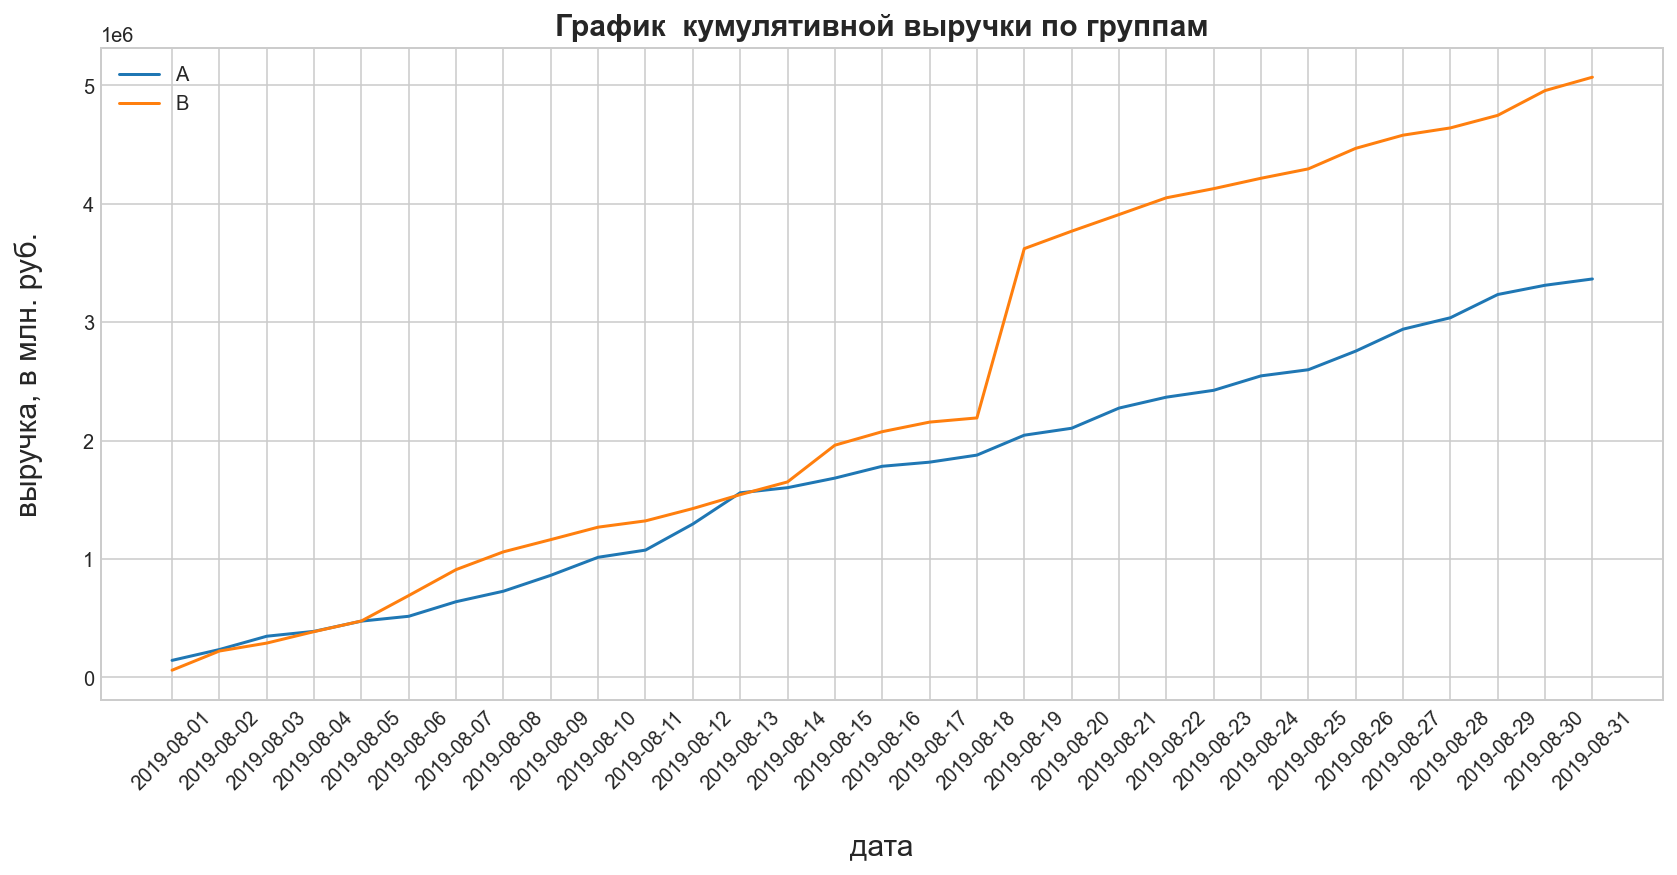

In [28]:
plt.plot(ordersACummulative['date'], ordersACummulative['total_revenue'], label='A')
plt.plot(ordersBCummulative['date'], ordersBCummulative['total_revenue'], label='B')
plt.legend()
plt.xticks(rotation=45)
ax = plt.gca()
ax.set_xlabel("дата", fontsize=15, labelpad=20)
ax.set_ylabel("выручка, в млн. руб.", fontsize=15, labelpad=20) 
ax.set_title('График  кумулятивной выручки по группам', \
              fontsize=15,  fontweight='bold')
rcParams['axes.titlepad'] = 20
# строим график кумулятивной выручки по группам

**Комментарий к полученному графику кумулятивной выручки по группам:**

- первые 3 дня выручка от пользователей из группы "А" была чуть выше, однако потом начался рост выручки  от пользователей из группы "B"
- так, 19 августа на графике выручки группы "B" можно наблюдать резкий рост выручки практически на 1,5 млн. рублей - видимо, у нас появился клиент-миллионер - далее при очистке данных данный заказ нужно будет удалить, поскольку он может исказить результаты исследования 
- к 19 дню теста совокупный доход от группы "B" была почти 2 млн. рублей больше, чем от группы "А"
- а к концу исследуемого периода разница составила порядка 1.6-1.8 млн. рублей в пользу пользователей из группы "B"

**Далее мы изучим как изменялся средний чек в каждой из групп**

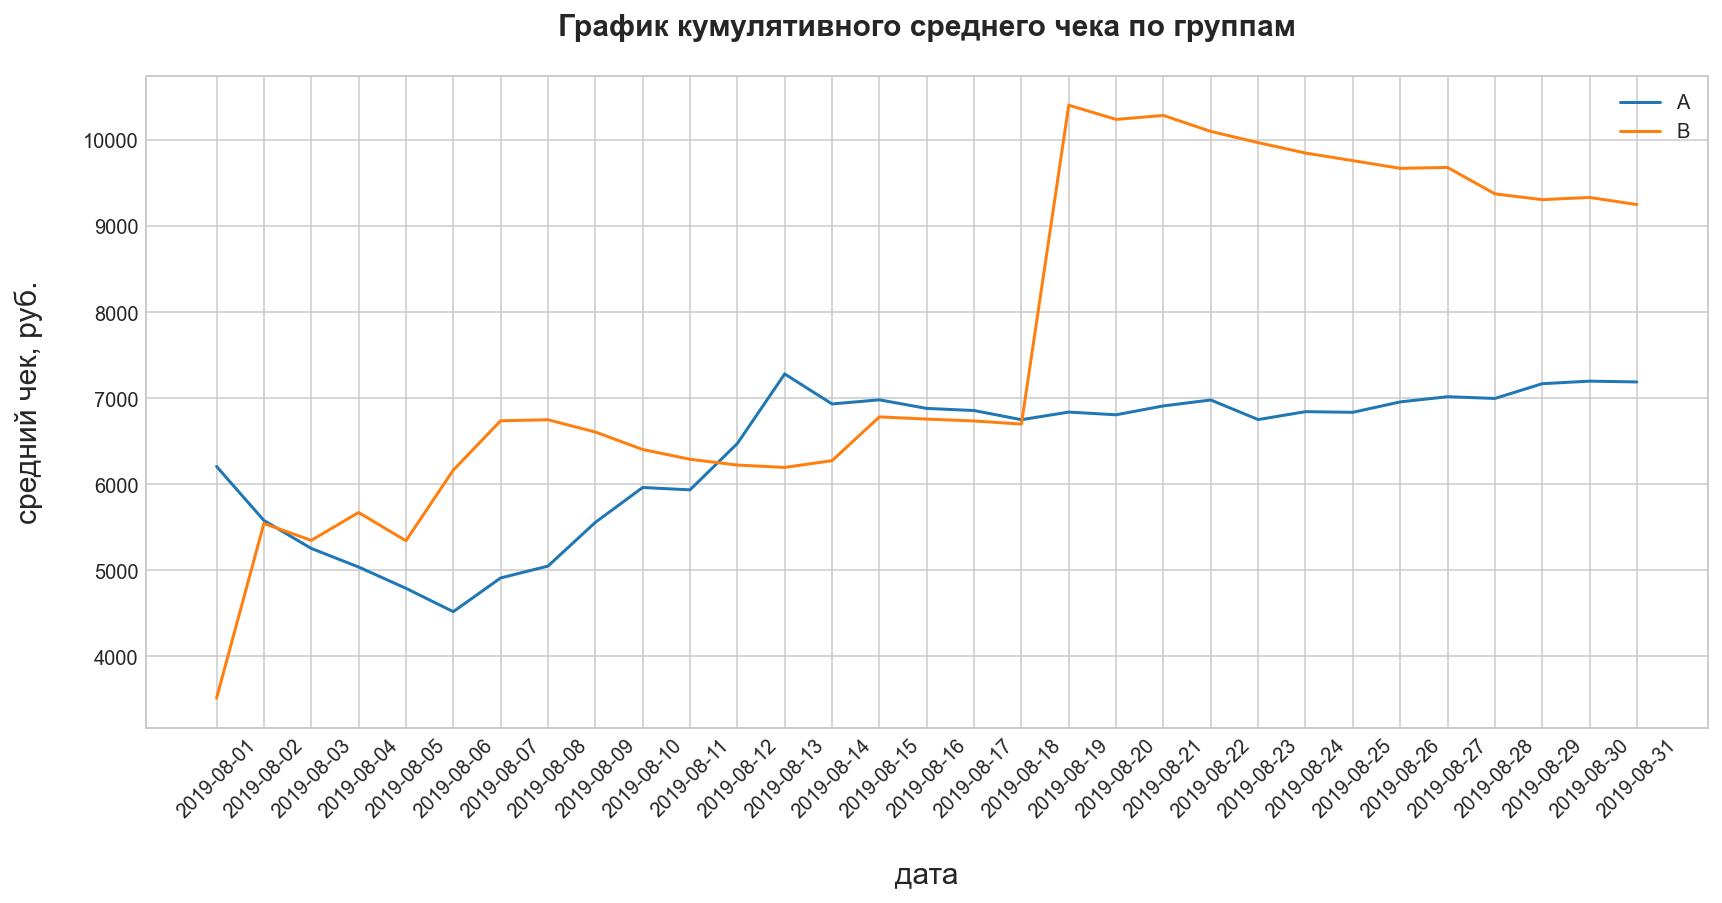

In [29]:
plt.plot(ordersACummulative['date'], ordersACummulative['total_revenue'] / ordersACummulative['total_orders'], label='A')
plt.plot(ordersBCummulative['date'], ordersBCummulative['total_revenue'] / ordersBCummulative['total_orders'], label='B')
plt.legend()
plt.xticks(rotation=45)
ax = plt.gca()
ax.set_xlabel("дата", fontsize=15, labelpad=20)
ax.set_ylabel("средний чек, руб.", fontsize=15, labelpad=20)
ax.set_title('График кумулятивного среднего чека по группам', \
              fontsize=15,  fontweight='bold')
rcParams['axes.titlepad'] = 20
# строим график кумулятивного среднего чека по группам

**Комментарий к полученному графику кумулятивной выручки по группам:**
 
- в первый день теста можно заметить, что пользователи из группы "B" совершили гораздо больше покупок, чем покупатели из группы "А", ведь средний чек вторых был выше примерно на 2000 рублей, при том, что выручка за этот день почти одинаковая
- со второго дня теста уже средний чек достиг значения первого дня группы "А" и уже к 6-му дню исследования достиг почти 7000 рублей
- у группы "А" ситуация обратная, однако это не свидетельствует о том, что заказов стало гораздо больше, ведь совокупная выручка от этой группы была стабильно ниже, чем у группы "B"
- на 19 день теста произошел резкий роста среднего чека  группы "B" примерно с 6800 рублей до 10500 рублей, что свидетельствует о том, что в этот день помимо обычных заказов был еще один заказ с непривычно большой суммой - что же это за заказ мы узнаем далее, когда будем строить точечные графики стоимостей заказов
- к концу исследуемого периода средний чек группы "B" был больше на 2000 рублей, чем у покупателей из группы "А"

**Далее мы изучим как изменялся средний чек в группе "B" относительно группы "А"**

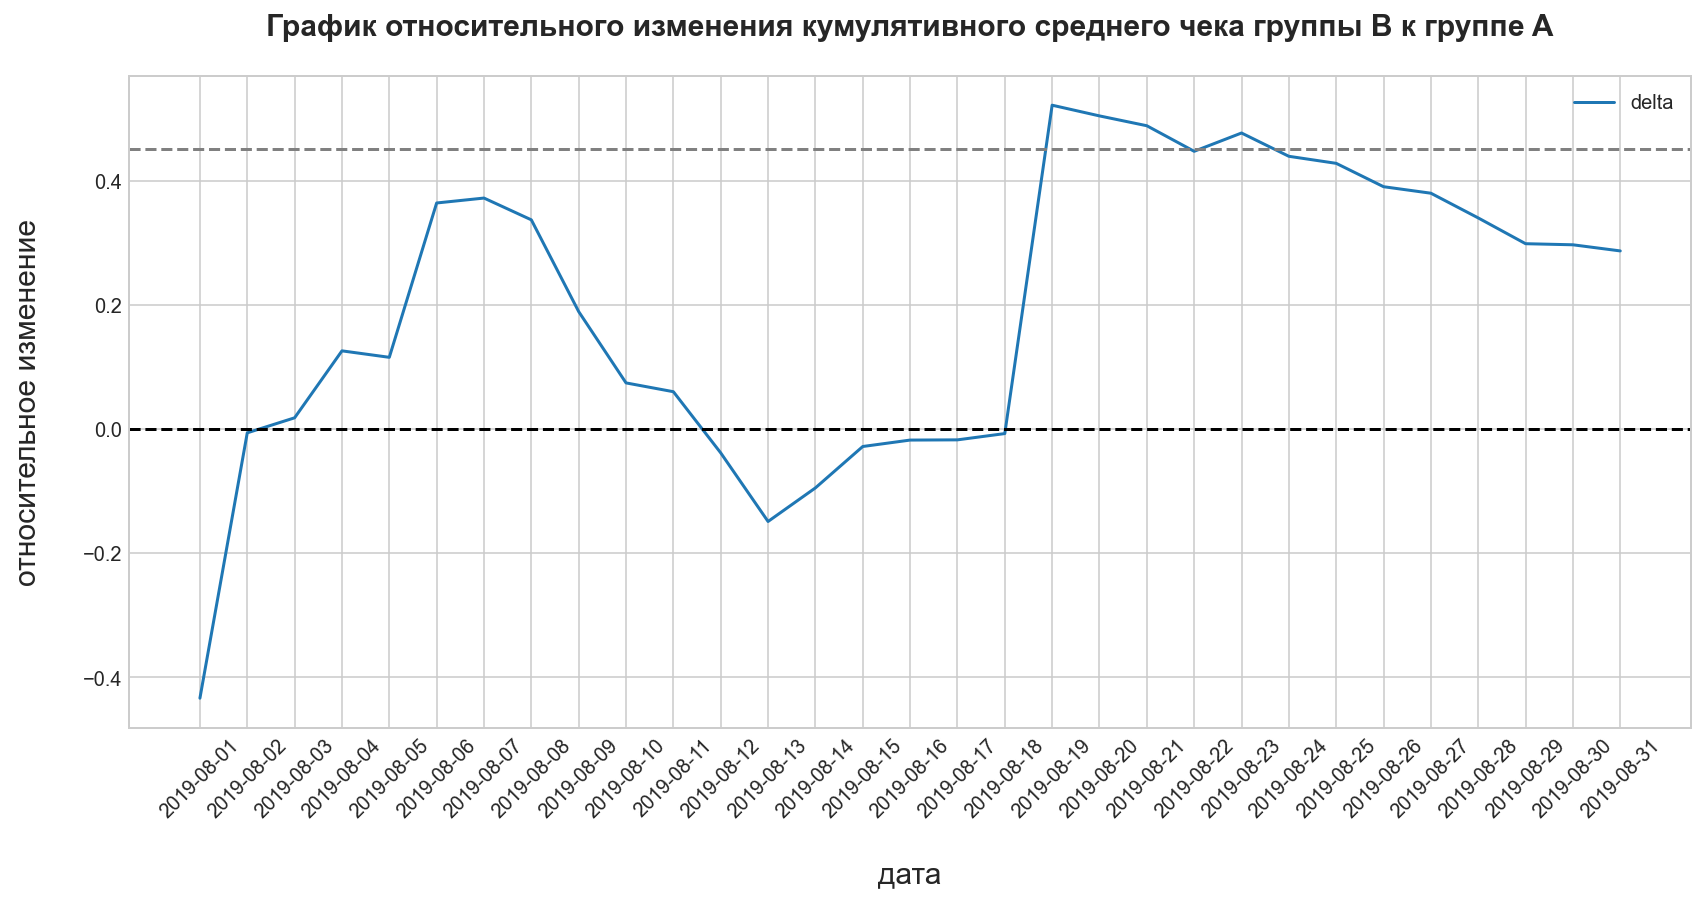

In [30]:
plt.plot(ordersACummulative['date'], (ordersBCummulative['total_revenue'] / ordersBCummulative['total_orders']) \
         / (ordersACummulative['total_revenue'] / ordersACummulative['total_orders']) - 1, label='delta')
plt.legend()
plt.axhline(y=0, color='black', linestyle='--')
plt.axhline(y=0.45, color='grey', linestyle='--')
plt.xticks(rotation=45)
ax = plt.gca()
ax.set_xlabel("дата", fontsize=15, labelpad=20)
ax.set_ylabel("относительное изменение", fontsize=15, labelpad=20)
ax.set_title('График относительного изменения кумулятивного среднего чека группы B к группе A', \
              fontsize=15,  fontweight='bold')
rcParams['axes.titlepad'] = 20
# строим график относительного изменения кумулятивного среднего чека группы B к группе A

**Комментарий к полученному графику кумулятивной выручки по группам:**
 
- говоря об относительных изменениях, стоит заметить, что в первый день средний чек группы "А" был выше на ~ 40%
- далее, весь исследуемый период, разница в средних чеках групп была не более 40% в пользу группы "B", за исключением 2 резких ростов среднего чека
- первый произошел у группы "А" на 12 день исследования - 12 августа - в этот день средний чек группы "B" стал ниже, чем у группы "А", но уже к 18 августа они почти сравнялись
- а 19 августа в группе "B" появился свой большой заказ, теперь средний чек группы "B" больше на 40+ %
- к концу исследуемого периода средний чек группы "B" был больше на ~ 30%, чем у покупателей из группы "А"

**Далее мы изучим как изменялось количество заказов по группам**

In [31]:
ordersACummulative['orders_per_usr'] = ordersACummulative['total_orders'] \
                                      / visitorsACummulative['visits_per_day']
# добавляем столбец со средним количетсвом заказов на 1 посетителя в выборке 'A'

In [32]:
ordersBCummulative['orders_per_usr'] = ordersBCummulative['total_orders']  \
                                      / visitorsBCummulative['visits_per_day']
# добавляем столбец со средним количетсвом заказов на 1 посетителя в выборке 'B'

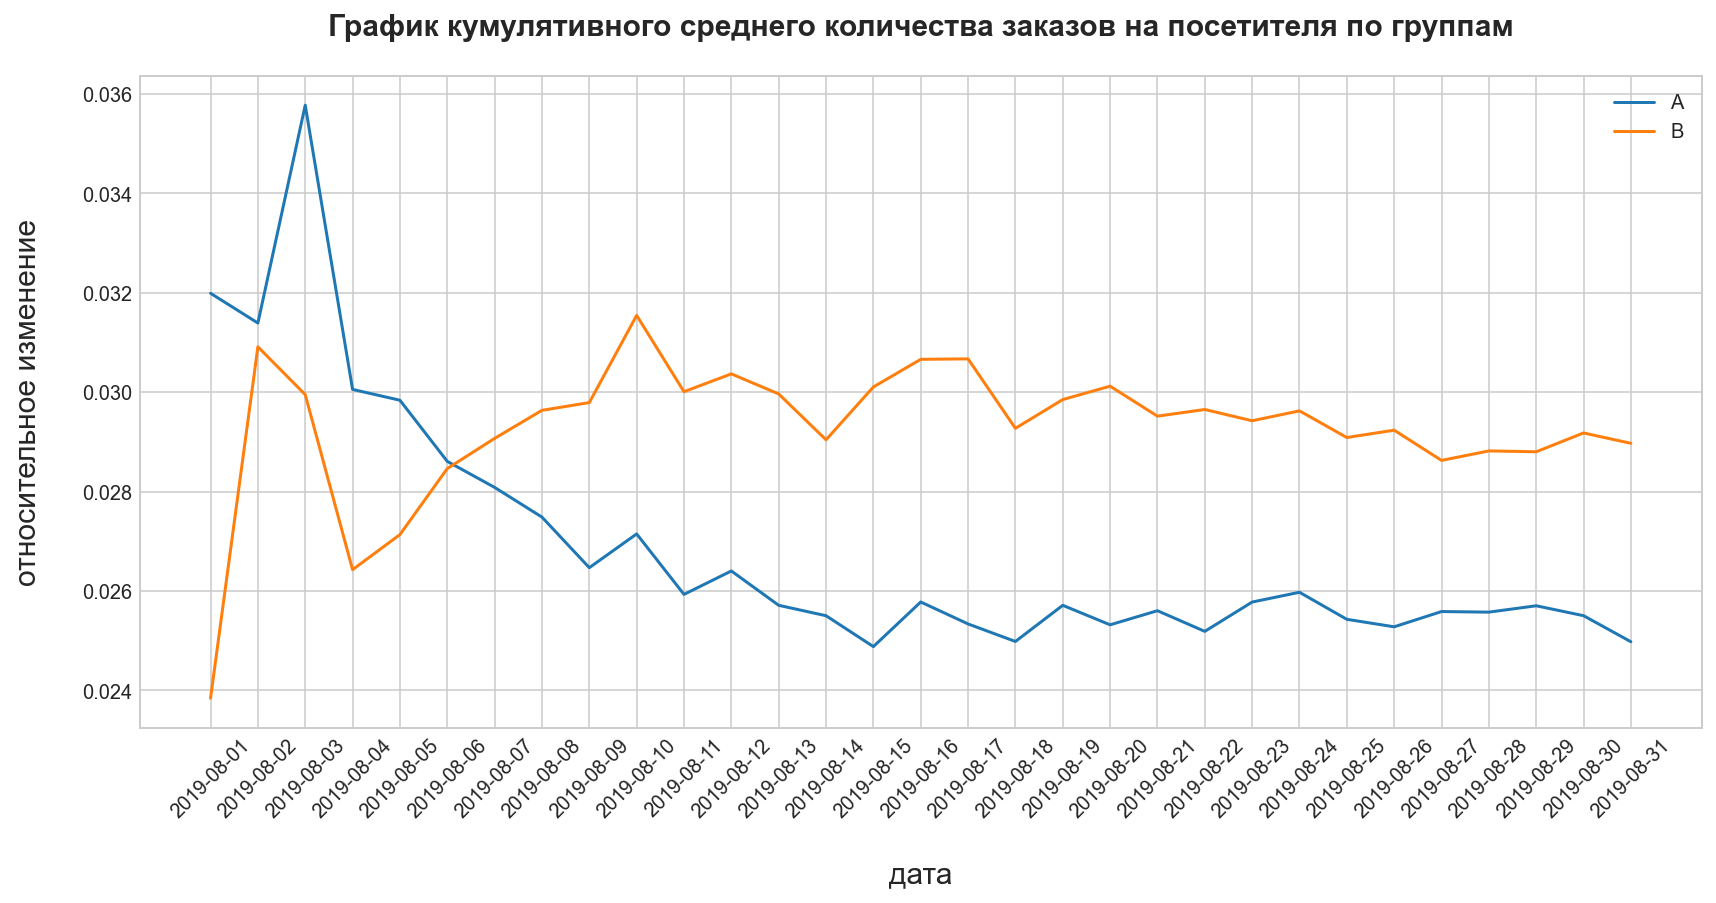

In [33]:
plt.plot(ordersACummulative['date'], ordersACummulative['orders_per_usr'], label='A')
plt.plot(ordersBCummulative['date'], ordersBCummulative['orders_per_usr'], label='B')
plt.legend()
plt.xticks(rotation=45)
ax = plt.gca()
ax.set_xlabel("дата", fontsize=15, labelpad=20)
ax.set_ylabel("среднее количество заказов на пользователя", fontsize=15, labelpad=20)
ax.set_ylabel("относительное изменение", fontsize=15, labelpad=20) 
ax.set_title('График кумулятивного среднего количества заказов на посетителя по группам', \
              fontsize=15,  fontweight='bold')
rcParams['axes.titlepad'] = 20
# строим график кумулятивного среднего количества заказов на посетителя по группам

**Комментарий к полученному графику кумулятивного среднего количества заказов на посетителя по группам:**

- первые 5 дней теста разница в среднем количестве заказов на посетителя группы "А" была выше от 0.001 до 0.008, что является значительным - разницой доходила до 20% и даже более
- изучая график группы "А" можно заметить, тенденцию на снижение с 3-его дня теста, которая продолжилась до самого конца исследования
- в случае графика группы "B" ситуация обратная, с 4 августа среднее количество заказов на пользователя начало расти и уже к 9 августа достигло своего максимума - практически 0.032 на пользователя
- с 9 и до последнего дня исследования оба графики колебались и к 26 августа относительно стабилизировались - группа "B" на уровне 0.029, а группы "А" - 0.025
- таким образом, хоть в начале теста среднее количество заказов на пользователя из группы "B" было меньше на 0.008, к концу оно стало больше на 0.004

**Далее мы изучим как изменялось количество заказов группы "B" относительно группы "А"**

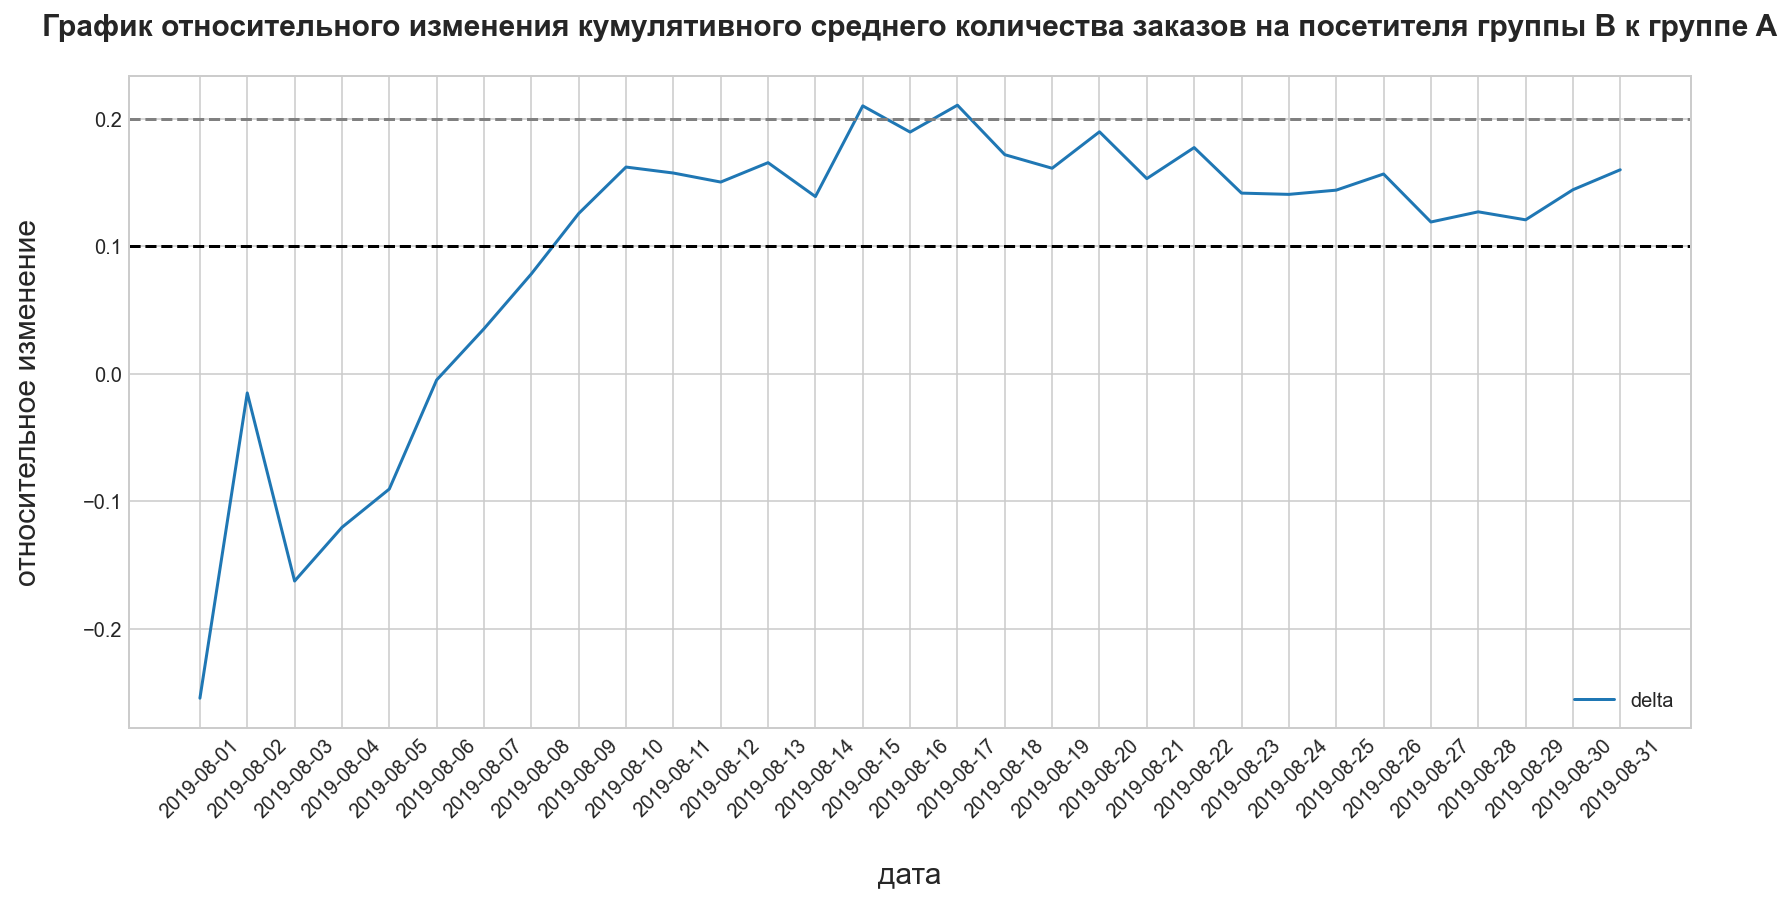

In [34]:
plt.plot(ordersACummulative['date'], (ordersBCummulative['orders_per_usr'] / ordersACummulative['orders_per_usr']) - 1, label='delta')
plt.legend()
plt.axhline(y=0.1, color='black', linestyle='--')
plt.axhline(y=0.2, color='grey', linestyle='--')
plt.xticks(rotation=45)
ax = plt.gca()
ax.set_xlabel("дата", fontsize=15, labelpad=20)
ax.set_ylabel("относительное изменение", fontsize=15, labelpad=20) 
ax.set_title('График относительного изменения кумулятивного среднего количества заказов на посетителя ' \
              'группы B к группе A', fontsize=15,  fontweight='bold')
rcParams['axes.titlepad'] = 20
# строим график относительного изменения кумулятивного среднего количества заказов на посетителя группы B к группе A

**Комментарий к полученному график относительного изменения кумулятивного среднего количества заказов на посетителя группы B к группе A:**

- как и говорилось выше, в первые 5 дней теста среднее количество заказов на посетителя группы "А" было значителньо выше, в первый день в группе "B" заказов на юзера было на ~ 25% меньше
- уже к 6 августа количество заказов на юзера в группах стало одинаковым
- далее заказов в группе "B" было на 0 - 20 % больше, чем в группе "А", за исключением 2-ух дней - 14 и 16 августа - в эти дни разница чуть-чуть превышала 20%
- в целом, практически на протяжении всего тест количетсво заказов группы "B" было выше на 10% и более 

**Далее мы изучим распределение количества заказов на покупателя**

In [35]:
ordersByUsers = (
    orders.groupby('visitor_id', as_index=False)
    .agg({'transaction_id': 'nunique'})
    .rename(columns={'transaction_id': 'am_orders'})
)
# создаем таблицу с количеством заказов каждого покупателя

In [36]:
x_values= pd.Series(range(0,len(orders['transaction_id'].unique())))
# создаем список значений для оси OX

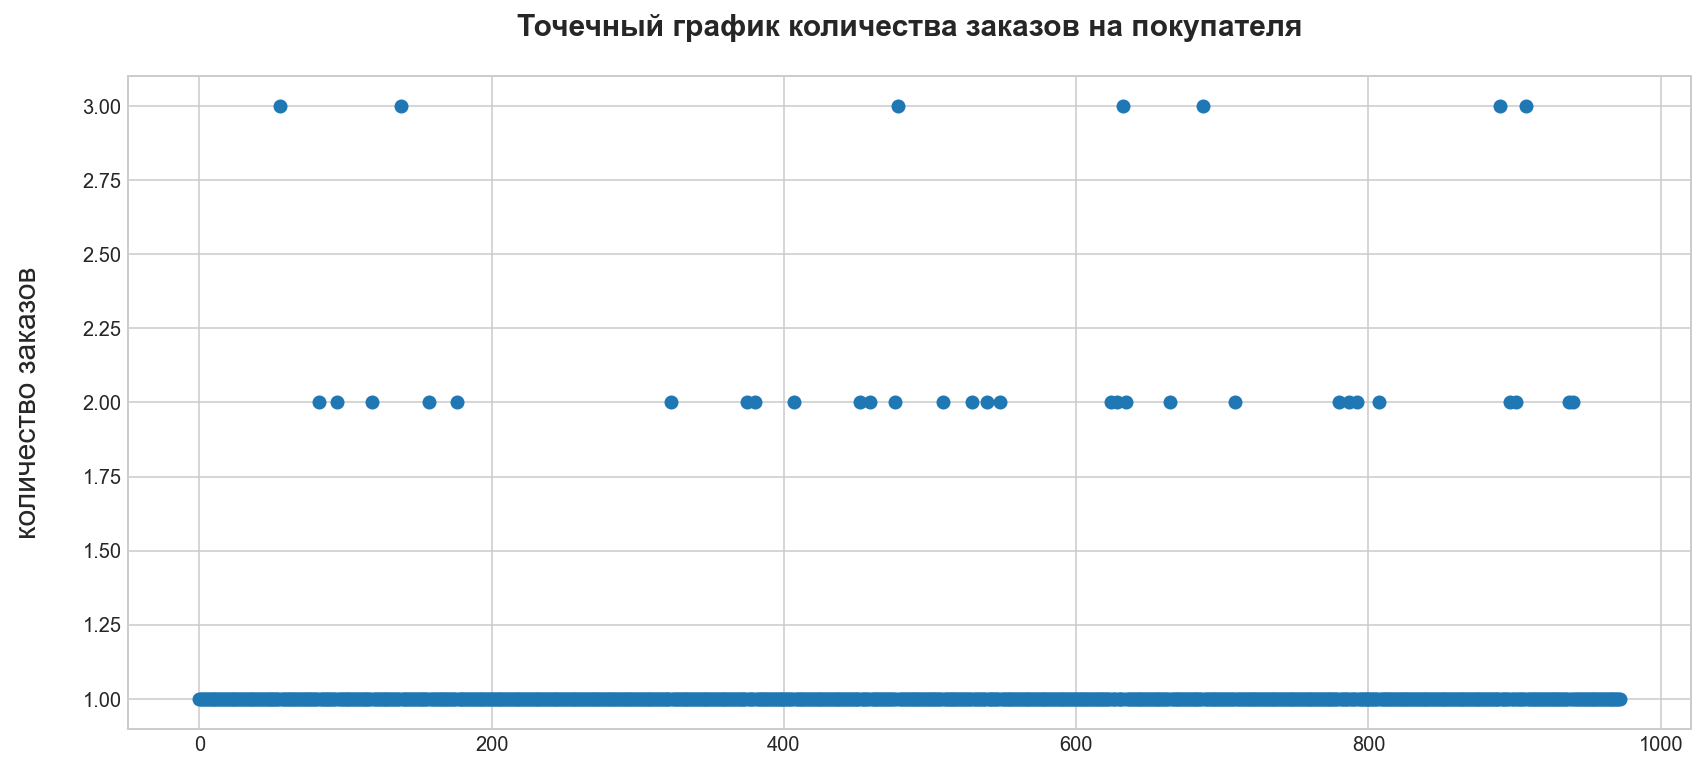

In [37]:
x_values = pd.Series(range(0,len(ordersByUsers)))
plt.scatter(x_values, ordersByUsers['am_orders'])
ax = plt.gca()
ax.set_ylabel("количество заказов", fontsize=15, labelpad=20) 
ax.set_title('Точечный график количества заказов на покупателя', fontsize=15,  fontweight='bold')
rcParams['axes.titlepad'] = 20
# строим график точечный график количества заказов на пользователям

**Комментарий к полученному точечному графику количества заказов на покупателя:**

- более 1 заказа совершается крайне редко - скорее всего, у нас продаются товары не повседневного спроса, поэтому крайне мало покупателей совершает повторную покупку в течениемесяца
- ну а людей, совершивших 3 заказа за август, еще меньше
- возможно, стоит пересмотреть товарный ассортимент, чтобы добавить дополнительный стимул к совершению повтороной покупки или же скорректировать свою маркетинговую стратегию - больше пушей, имэйлов, ремаркетинга в соц. сетях и других способов коммуникации с аудиторией, которая уже совершила заказ у нас

**Далее мы изучим 95-й и 99-й перцентили количества заказов на пользователя**

In [38]:
np.percentile(ordersByUsers['am_orders'], [95, 99])
# считаем 95-й и 99-й перцентили количества заказов на пользователя. 

array([1., 2.])

**Комментарий к полученному выводу по 95-ому и 99-ому перцентилю количества заказов на пользователя:**

- лишь 1% пользователей оформлял 2 и более заказа, поэтому разумно будет выбрать 1 заказ на пользователя за верхнюю границу числа заказов, и отсеять аномальных пользователей по ней

**Далее мы займемся удалением таких строк**

In [39]:
ordersByUsersA = (
    orders.query('group=="A"')
    .groupby('visitor_id', as_index=False)
    .agg({'transaction_id': 'nunique'})
    .rename(columns={'transaction_id': 'am_orders'})
)
# создаем таблицу с заказами покупателей из группы 'A'

In [40]:
ordersByUsersB = (
    orders.query('group=="B"')
    .groupby('visitor_id', as_index=False)
    .agg({'transaction_id': 'nunique'})
    .rename(columns={'transaction_id': 'am_orders'})
)
# создаем таблицу с заказами покупателей из группы 'B'

In [41]:
usersWithManyOrders = pd.concat(
    [
        ordersByUsersA[ordersByUsersA['am_orders'] > 
        np.percentile(ordersByUsers['am_orders'], [95, 99])[0]]
        ['visitor_id'],
        ordersByUsersB[ordersByUsersB['am_orders'] > 
        np.percentile(ordersByUsers['am_orders'], [95, 99])[0]]
        ['visitor_id'],
    ],
    axis=0,
)
# создаем таблицу с айдишниками покупателей, совершивших более 1 заказа, которые являются выбросами, из обеих групп

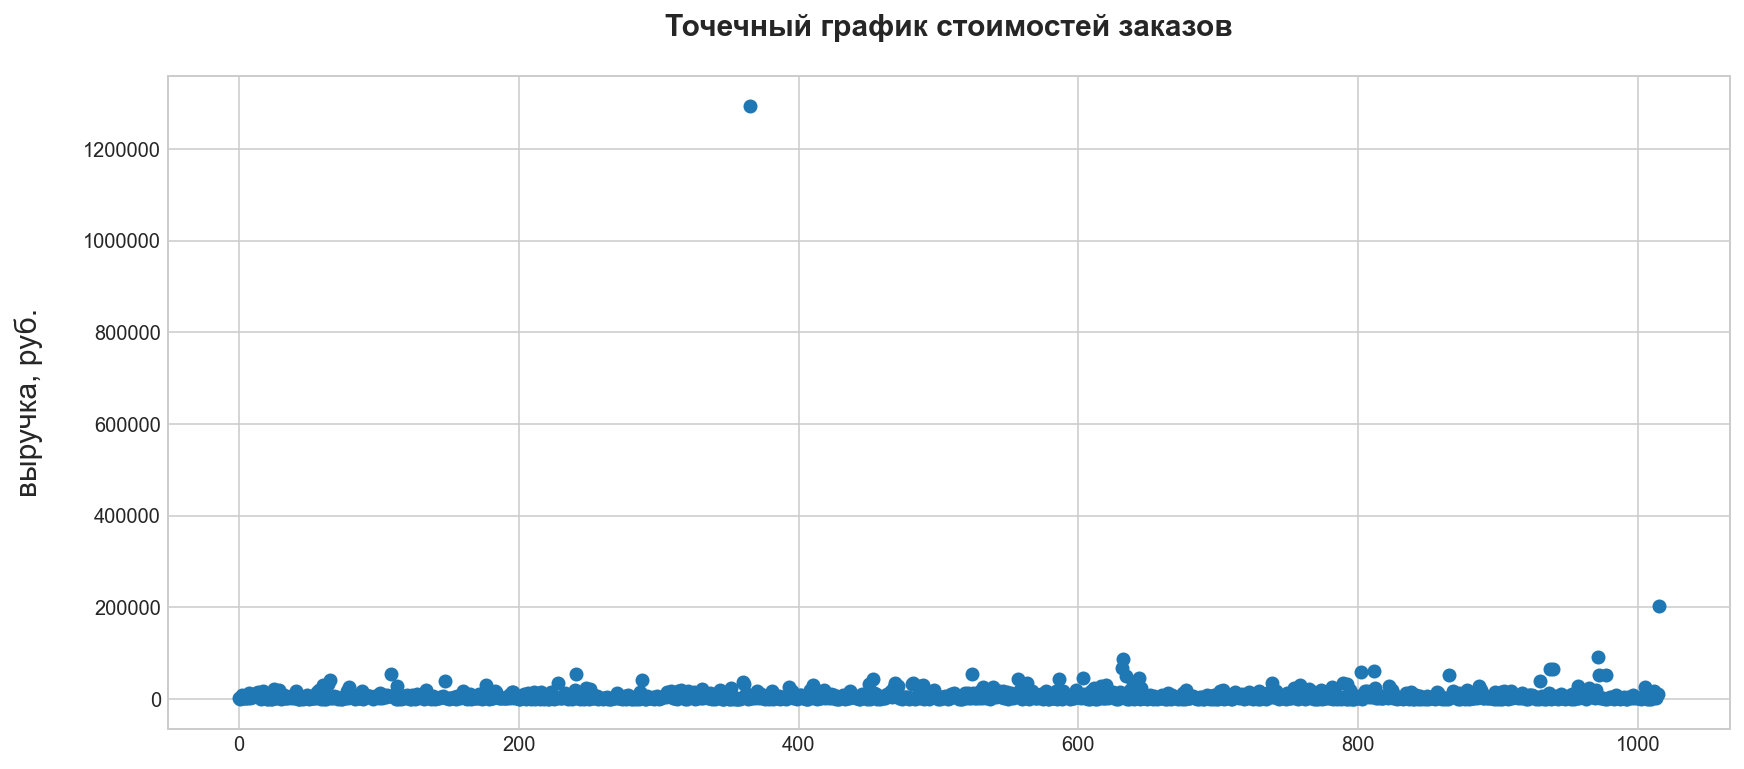

In [42]:
x_values = pd.Series(range(0,len(orders)))
plt.scatter(x_values, orders['revenue'])
ax = plt.gca()
ax.set_ylabel("выручка, руб.", fontsize=15, labelpad=20) 
ax.set_title('Точечный график стоимостей заказов', fontsize=15,  fontweight='bold')
ax.ticklabel_format(style='plain')
rcParams['axes.titlepad'] = 20
# строим график точечный график стоимостей заказов

**Поскольку по полученному точечному графику стоимостей заказов сложно что либо понять, ограничем значения "стоимости заказа" (оси OY) и запомним, что у нас есть один выброс в районе 200.000 рублей и где-то свыше 1.200.000 затаился выброс (поскольку оси графика строятся от минимальных до максимальных значения)**

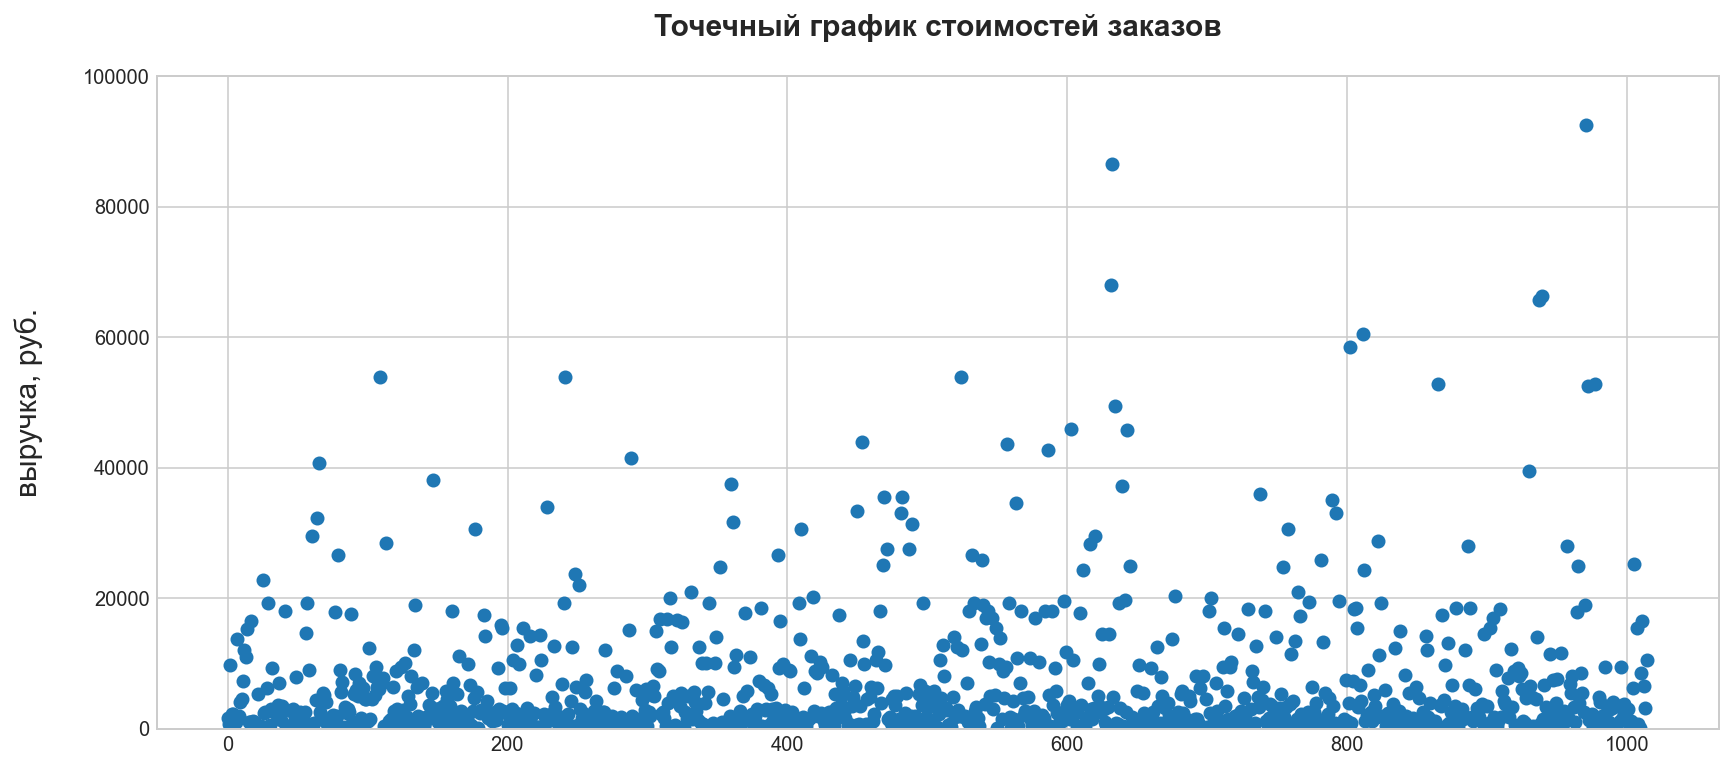

In [43]:
x_values = pd.Series(range(0,len(orders)))
plt.scatter(x_values, orders['revenue'])
ax = plt.gca()
ax.set_ylabel("выручка, руб.", fontsize=15, labelpad=20) 
ax.set_title('Точечный график стоимостей заказов', fontsize=15,  fontweight='bold')
ax.ticklabel_format(style='plain')
plt.ylim((0,100000))
rcParams['axes.titlepad'] = 20
# строим график точечный график стоимостей заказов

**Комментарий к полученному точечному графику стоимостей заказов:**

- на предыдущем графике мы узнали, какие же были заказы, которые повышали средний чек, один на 200.000 рублей, скорее всего, из группы "А", и один на сумму более 1.200.000 рублей - скорее всего из группы "B" - кто-то решил закупиться на всю оставшуюся жизнь
- по более детальному графику видно, что большинство заказов не превышает 20.000 рублей
- заказов в пределах 40.000 рублей не так уж и мало, а вот заказы свыше 40.000 рублей уже можно считать "единичными"

**Далее мы изучим 95-й и 99-й перцентили стоимости заказов**

In [44]:
np.percentile(orders['revenue'], [95, 99])
# считаем 95-й и 99-й перцентили стоимости заказов

array([26785., 53904.])

**Комментарий к полученному выводу по 95-ому и 99-ому стоимости заказов:**

- лишь у 1 % всех заказов стоиомть свыше 53904 рублей, поэтому разумно будет выбрать 26785 рублей за верхнюю границу стоимости заказа, и отсеять аномальных пользователей по ней

**Далее мы займемся удалением таких строк**

In [45]:
usersWithExpensiveOrders = orders[orders['revenue'] > \
    np.percentile(orders['revenue'], [95, 99])[0]]['visitor_id']
# создаем таблицу с айдишниками покупателей с суммой заказа более 26785 рублей
# поскольку это выбросы - таких пользователей лишь 1% 

In [46]:
abnormalUsers = (
    pd.concat([usersWithManyOrders, usersWithExpensiveOrders], axis=0)
    .drop_duplicates()
    .sort_values()
)
# объединяем 2 таблицы с айдишниками пользователей, чьи заказы являются выбросами

**Далее мы подготовим выборки "сырых" и "очищенных" данных для расчета статистической значимости различий в среднем количестве заказов на посетителя и среднем чеке заказа между группами**

In [47]:
sampleA = pd.concat([
    ordersByUsersA['am_orders'], pd.Series(0, index=np.arange(
        DailyVisitsA['visitors'].sum() - len(ordersByUsersA['am_orders'])
                                          ),
    name='am_orders',
    ),
],
    axis=0,
)
# создаем таблицу с заказами пользователей из группы 'A'

In [48]:
sampleB = pd.concat([
    ordersByUsersB['am_orders'], pd.Series(0, index=np.arange(
        DailyVisitsB['visitors'].sum() - len(ordersByUsersB['am_orders'])
                                          ),
    name='am_orders',
    ),
],
    axis=0,
)
# создаем таблицу с заказами пользователей из группы 'B'

**Далее мы проверим статистическую значимость различий в среднем количестве заказов на посетителя между группами по «сырым» данным**

H0: различий в среднем количестве заказов на посетителя группами нет

H1: различия в среднем количестве заказов на посетителя группами есть. 

In [49]:
print('{:.5f}'.format(stats.mannwhitneyu(sampleA, sampleB)[1]))
print("{0:.3f}".format(sampleB.mean() / sampleA.mean() - 1))
# считаем статистическую значимость различий в среднем количестве заказов 
# на посетителя между группами по «сырым» данным
# а также посчитаем относительное значение среднего числа заказов группы 'B' к группе 'A'

0.01102
0.160


**Комментарий к полученному выводу:**

- поскольку мы получили **p-value меньше 0.05**, то мы отвергаем нулевую гипотезу и принимаем альтернативную, что среднее количество заказов на пользователя между группами на самом деле разное
- ведь посчитав относительное значение среднего числа заказов группы 'B' к группе 'A', можно увидеть, что есть **разница в 16%** на нашей выборке

**Далее мы проверим статистическую значимость различий в среднем чеке между сегментами**

H0: различий в среднем чеке между группами нет

H1: различия в среднем чеке между группами есть. 

In [50]:
print('{0:.3f}'.format(stats.mannwhitneyu(orders[orders['group']=='A']['revenue'], \
                                          orders[orders['group']=='B']['revenue'])[1]))
print('{0:.3f}'.format(orders[orders['group']=='B']['revenue'].mean() \
                       / orders[orders['group']=='A']['revenue'].mean() - 1))
# считаем статистическую значимость различий
# в среднем чеке заказа между группами по «сырым» данным
# а также посчиатем относительное значение среднего чека группы 'B' к группе 'A' по "сырым" данным

0.829
0.287


**Комментарий к полученному выводу:**

- поскольку мы получили **p-value больше 0.05**, то у нас нет оснований для того, чтобы отвергнуть нулевую гипотезу о том, что средние чеки двух выборок одинаковые
- однако несмотря на это, в данном случае **средний чек** группы 'B' был **больше на 28,7%**, что в потенциале может являться весомым аргументом в пользу нулевой гипотезы

**Далее мы проверим создадим таблицы без учета выбросов**

In [51]:
sampleAFiltered = pd.concat(
    [ 
         ordersByUsersA[np.logical_not(ordersByUsersA['visitor_id'].isin(abnormalUsers))]['am_orders'],
       pd.Series(0, index=np.arange(
        DailyVisitsA['visitors'].sum() - len(ordersByUsersA['am_orders'])
                                          ),
    name='am_orders',
    ),
],
    axis=0,
)
# создаем выборку с очищенными данными пользователей группы 'A'

In [52]:
sampleBFiltered = pd.concat(
    [ 
         ordersByUsersB[np.logical_not(ordersByUsersB['visitor_id'].isin(abnormalUsers))]['am_orders'],
       pd.Series(0, index=np.arange(
        DailyVisitsB['visitors'].sum() - len(ordersByUsersB['am_orders'])
                                          ),
    name='am_orders',
    ),
],
    axis=0,
)
# создаем выборку с очищенными данными пользователей группы 'B'

**Теперь мы проведем статистический тест уже по "очищенным" данным и проверим отличается ли среднее количество заказов на пользователя из группы "A" и группы "B"**

H0: различий в среднем количестве заказов на посетителя группами нет

H1: различия в среднем количестве заказов на посетителя группами есть. 

In [53]:
print('{:.5f}'.format(stats.mannwhitneyu(sampleAFiltered, sampleBFiltered)[1]))
print("{0:.3f}".format(sampleBFiltered.mean() / sampleAFiltered.mean() - 1))
# считаем статистическую значимость различий в среднем количестве заказов 
# на посетителя между группами по «очищенным» данным
# а также посчитаем относительный прирост среднего числа заказов группы B

0.01593
0.174


**Комментарий к полученному выводу:**

- поскольку мы получили **p-value меньше 0.05**, то мы отвергаем нулевую гипотезу и принимаем альтернативную, что среднее количество заказов на пользователя между группами на самом деле разное
- стоит заметить, что после удаления выбросов значение p-value увеличилось на 0.0049, что говорит о том, что выбросы чуть-чуть уравнивали средние чеки групп - однако это было совсем не значительно
- а также среднее количество заказов группы "B" **больше на 17,4%** по сравнению с "A" 
- по сравнению с тестом по **"сырыми" данным**, мы получили **прирост 1,4%** в среднем количестве заказов на пользователя

**Далее мы проверим статистическую значимость различий в среднем чеке между сегментами**

H0: различий в среднем чеке между группами нет

H1: различия в среднем чеке между группами есть. 

In [54]:
print('{:.3f}'.format(stats.mannwhitneyu( \
    orders[np.logical_and( \
                    orders['group'] == 'A', \
                    np.logical_not(orders['visitor_id'].isin(abnormalUsers)) \
                                         )]['revenue'],
    orders[np.logical_and( \
                    orders['group'] == 'B', \
                    np.logical_not(orders['visitor_id'].isin(abnormalUsers)) \
                                         )]['revenue'])[1]
               )
     )
# считаем статистическую значимость различий
# в среднем чеке заказа между группами по «очищенным» данным

0.727


**Комментарий к полученному выводу:**

- поскольку мы получили **p-value больше 0.05**, то у нас нет оснований для того, чтобы отвергнуть нулевую гипотезу о том, что среднее количество заказов на пользователя между группами одинаковое

**Подводя итог статистическим тестам, можно сказать:**

- есть статистически значимые отличия в среднем количестве заказов между группами - так к концу теста мы можем наблюдать, что на одного пользователя из группы "B" приходится на 15% больше заказов
- однако по среднему чеку у нас нет статистически значимых различий, несмотря на то, что на графике изменения среднего чека группы "B" относительно группы "А" можно наблюдать разницу от 20 % до целых 40% в течение теста (в пользу группы "B"), а к концу исследования средний чек группы "B" оказался выше на 25%

**Далее мы посчитаем относительные различия в среднем чеке между группами, чтобы убедиться в правильности сделанных выводов**

In [55]:
print('{:.3f}'.format(\
    orders[np.logical_and( \
                    orders['group'] == 'B', \
                    np.logical_not(orders['visitor_id'].isin(abnormalUsers)) \
                                         )]['revenue'].mean() / \
    orders[np.logical_and( \
                    orders['group'] == 'A', \
                    np.logical_not(orders['visitor_id'].isin(abnormalUsers)) \
                                         )]['revenue'].mean() - 1)
               )
# счиатем относительное изменение в среднем чеке между группами по "очищенным" данным

-0.034


**Комментарий к полученному выводу:**

- поскольку мы получили отрицательное число, то можно утверждать, что выводы, сделанные выше, верные, и у нас нет статистически значимых результатов, чтобы утверждать, что есть различия в среднем чеке между группами

## Часть 4. Выводы

**Принимая во внимание все графики и факты, полученные во время исследования, я считаю, что тест можно завершить и остановиться на том, что он был успешным, по ряду причин:**

- во-первых, в группе "B" выросло среднее количество заказов на одного пользователя
- во-вторых, несмотря на то, что среднее количество заказов на одного пользователя из группы "B" увеличилось, на средний чек в данной группе это почти никак не повлияло - то есть количество заказов в группе "B" стало больше не за счет много новых мелких заказов, а за счет заказов со стандартным средним чеком - это с учетом удаления выбросов
- в-третьих, при прочих равных условиях в долгосрочной перспективе пользователи из группы "B" принесут гораздо больше выручки, ведь помимо того, что у них среднее количество заказов на пользователя больше, их опыт взаимодействия с нашим магазином будет закрепляться качественным сервисом, что повысит их уровень лояльности, тем самым, повысится и уровень удержания

**Я считаю, что данную фичу можно выкатывать на продакшен**